---
title: "Learning how to make and use SuperPlots"
subtitle: "A reference to visualize experimental variability in biological data following the SuperPlots philosophy by [Samuel J. Lord et al. 2020](https://doi.org/10.1083/jcb.202001064)"
author: Marco Dalla Vecchia
date: 12/06/2024
---

In [9]:
# Let's import the packages we will need

import pandas as pd # essential to handle table objects (dataframes)
from matplotlib import pyplot as plt # one of the most important libraries to create scientific visualization in Python
import matplotlib.ticker as ticker # utility import to change ticks frequency on an axis
import seaborn as sns # great package built on matplotlib to create grouped-data plots
from scipy.stats import ttest_rel, ttest_ind # calculate t-test between related and independent samples in Python

# Aesthetics
plt.rcParams["font.family"] = "serif" # use Serif style as default font

In [10]:
# Read data from original publication
# find it here https://doi.org/10.1083/jcb.202001064
df = pd.read_csv('../data/jcb_202001064_datas1.txt')

In [11]:
# I divided each subplot into its own function to avoid overcrowding and allow for modularity
# I called each plot with its 'judgement' name in the original publication

def create_nope_plot(df, ax):

    # Get 'wrong' p-value pretending Control and Drug treatments are independent samples with N=300
    bad_pvalue = ttest_ind(
            df.loc[lambda df_: df_.Treatment == 'Control']['Speed'], # all speed values for Control
            df.loc[lambda df_: df_.Treatment == 'Drug']['Speed'] # all speed values for Drug
        ).pvalue

    # Create plot
    sns.barplot( # a simple barplot with errorbars grouping all the samples together
        data=df, x='Treatment', y='Speed',
        color='gray', edgecolor='black', lw=1.5,
        capsize=.4, err_kws={"color": "black", "linewidth": 1.5},
        ax=ax
    )

    # Plot adjustments
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0,60)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_ylabel(r'Speed ($\mu$m/min)')
    x1, x2 = 0, 1
    y, h = df['Speed'].max() + 2, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h*2, "P = {:.17f}".format(bad_pvalue), ha='center', va='bottom')
    ax.set_facecolor('#F0F0F7')
    sns.despine()

    return ax

def create_still_nope_plot(df, ax):
    # Get 'wrong' p-value pretending Control and Drug treatments are independent samples with N=300
    bad_pvalue = ttest_ind(
            df.loc[lambda df_: df_.Treatment == 'Control']['Speed'], 
            df.loc[lambda df_: df_.Treatment == 'Drug']['Speed']
        ).pvalue

    # Create plot
    sns.swarmplot( # all datapoints shown as a swarmplot not separated by replicate
        data=df, x='Treatment', y='Speed',
        size=4, zorder=0, color='#F0F0F7',
        linewidth=0.6, edgecolor='.1',
        legend=False, ax=ax
    )

    sns.pointplot( # global errorbars considering all replicates together
        data=df, x='Treatment', y='Speed', linestyle="none", 
        capsize=.2, errorbar=('ci',95), err_kws={'linewidth': 1.4},
        marker="_", markersize=50, markeredgewidth=1.4, color='black', legend=False,
        ax=ax
    )
    
    # Plot adjustments
    sns.despine()
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0,60)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_ylabel(r'Speed ($\mu$m/min)')
    x1, x2 = 0, 1
    y, h = df['Speed'].max() + 2, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h*2, "P = {:.17f}".format(bad_pvalue), ha='center', va='bottom')
    ax.set_facecolor('#F0F0F7')
    return ax

def create_ok_plot(df, ax):
    # Actually consider the replicates
    # Consider mean value of each replicate per treatment
    # directly taken from S5 of original publication
    ReplicateAverages = df.groupby(['Treatment','Replicate'], as_index=False).agg({'Speed': "mean"}); 
    ReplicateAvePivot = ReplicateAverages.pivot_table(columns='Treatment', values='Speed', index="Replicate")
    # Calculate 'appropriate' p-value considering n=3
    good_pvalue = ttest_rel(ReplicateAvePivot['Control'], ReplicateAvePivot['Drug']).pvalue

    # Create plot
    sns.pointplot( # standard error bars of mean values of each replicate
        data=ReplicateAverages, x='Treatment', y='Speed', linestyle="none", 
        capsize=.4, errorbar='se', err_kws={'linewidth': 1.4},
        marker="_", markersize=50, markeredgewidth=1.4, color='black', legend=False,
        ax=ax
    )

    sns.pointplot( # one dot per replicate all same color
        data=df, x='Treatment', y='Speed', hue='Replicate',
        palette=["darkgray","darkgray","darkgray"], linestyle="none", errorbar=None,
        markeredgecolor='k', markeredgewidth=1.1, legend=False, ax=ax
    )

    # Plot adjustments
    sns.despine()
    ax.set_ylabel(r'Speed ($\mu$m/min)')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0,60)

    x1, x2 = 0, 1
    y, h = df['Speed'].max() + 2, 2

    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h*2, "P = {:.3f}".format(good_pvalue), ha='center', va='bottom')
    ax.set_facecolor('#F0F0F7')
    return ax

def create_better_plot(df, ax):
    # Actually consider the replicates
    # Consider mean value of each replicate per treatment
    # directly taken from S5 of original publication    
    ReplicateAverages = df.groupby(['Treatment','Replicate'], as_index=False).agg({'Speed': "mean"}); 
    ReplicateAvePivot = ReplicateAverages.pivot_table(columns='Treatment', values='Speed', index="Replicate")
    # Calculate 'appropriate' p-value considering n=3
    good_pvalue = ttest_rel(ReplicateAvePivot['Control'], ReplicateAvePivot['Drug']).pvalue

    # Just to copy the colors in the paper I extract the RGB values from the original figure
    paper_palette = [
        (0.792156862745098, 0.5529411764705883, 0.1411764705882353), 
        (0.36470588235294116, 0.6274509803921569, 0.7490196078431373), 
        (0.5803921568627451, 0.592156862745098, 0.592156862745098)
    ]

    # Create plot
    sns.swarmplot( # all data points as swarmplot not colored by replicates
        data=df, x='Treatment', y='Speed',
        size=3, zorder=0, color='.8',
        linewidth=0.8, edgecolor='.7',
        legend=False, ax=ax
    )

    sns.pointplot( # standard error bars of mean values of each replicate
        data=ReplicateAverages, x='Treatment', y='Speed', linestyle="none", 
        capsize=.4, errorbar='se', err_kws={'linewidth': 1.4},
        marker="_", markersize=50, markeredgewidth=1.4, color='black', legend=False,
        ax=ax
    )

    sns.pointplot( # one dot representing mean of each replicate separated by color and marker type
        data=df, x='Treatment', y='Speed', hue='Replicate',
        palette=paper_palette, linestyle="none", errorbar=None, markers=['o','s','^'], dodge=False,
        markeredgecolor='k', markeredgewidth=1.1, legend=False, ax=ax
    )

    # Plot adjustments
    sns.despine()
    ax.set_ylabel(r'Speed ($\mu$m/min)')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0,60)

    x1, x2 = 0, 1
    y, h = df['Speed'].max() + 2, 2

    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h*2, "P = {:.3f}".format(good_pvalue), ha='center', va='bottom')
    ax.set_facecolor('#F0F0F7')
    return ax

def create_superplot(df, ax):
    # Actually consider the replicates
    # Consider mean value of each replicate per treatment
    # directly taken from S5 of original publication    
    ReplicateAverages = df.groupby(['Treatment','Replicate'], as_index=False).agg({'Speed': "mean"}); 
    ReplicateAvePivot = ReplicateAverages.pivot_table(columns='Treatment', values='Speed', index="Replicate")
    # Calculate 'appropriate' p-value considering n=3
    good_pvalue = ttest_rel(ReplicateAvePivot['Control'], ReplicateAvePivot['Drug']).pvalue
    
    # Just to copy the colors in the paper I extract the RGB values from the original figure
    paper_palette = [
        (0.792156862745098, 0.5529411764705883, 0.1411764705882353), 
        (0.36470588235294116, 0.6274509803921569, 0.7490196078431373), 
        (0.5803921568627451, 0.592156862745098, 0.592156862745098)
    ]

    # Instead of making the background swarmplot white I kept the corresponding categorical color
    # but lower the opacity down by 50%
    # this is the largest difference with the original figure
    alpha_palette = [
        (r,g,b,0.5)
        for (r,g,b) in paper_palette
    ]

    sns.swarmplot( # plot all data points by replicate as swarmplot
        data=df, x='Treatment', y='Speed', hue='Replicate',
        size=4, zorder=0, palette=alpha_palette,
        linewidth=1, legend=False, ax=ax
    )

    sns.pointplot( # standard error bars of mean values of each replicate
        data=ReplicateAverages, x='Treatment', y='Speed', linestyle="none", 
        capsize=.3, errorbar='se', err_kws={'linewidth': 1.4},
        marker="_", markersize=50, markeredgewidth=1.4, color='black', legend=False, ax=ax
    )

    sns.pointplot( # one dot representing mean of each replicate separated by color and marker type
        data=df, x='Treatment', y='Speed', hue='Replicate',
        palette=paper_palette, linestyle="none", errorbar=None, markers=['o','s','^'], dodge=True,
        markeredgecolor='k', markeredgewidth=1.1, legend=False, ax=ax
    )

    # Plot adjustments
    sns.despine()
    ax.set_ylabel(r'Speed ($\mu$m/min)')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0,60)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))


    x1, x2 = 0, 1
    y, h = df['Speed'].max() + 2, 2

    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h*2, "P = {:.3f}".format(good_pvalue), ha='center', va='bottom')
    ax.set_facecolor('#F0F0F7')
    return ax

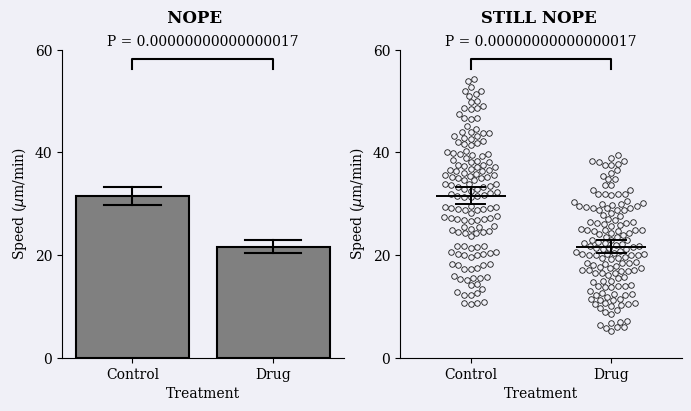

In [12]:
#| label: fig-bad-figure
#| fig-cap: "Replica of bad figure from @lord_superplots_2020"

# Create 'bad' figure

# Iniziatilize figure with background color from original figure
fig, axes = plt.subplots(1,2, figsize=(8,4), facecolor='#F0F0F7')

# Create figure for each subplot
create_nope_plot(df, axes[0])
create_still_nope_plot(df, axes[1])

# Add label in the stupidiest way I could find
fig.suptitle('       NOPE                                             STILL NOPE', fontweight='bold')

# Save figure without padding
fig.savefig('../figures/bad-figure.pdf', bbox_inches='tight', pad_inches=0, transparent=True)

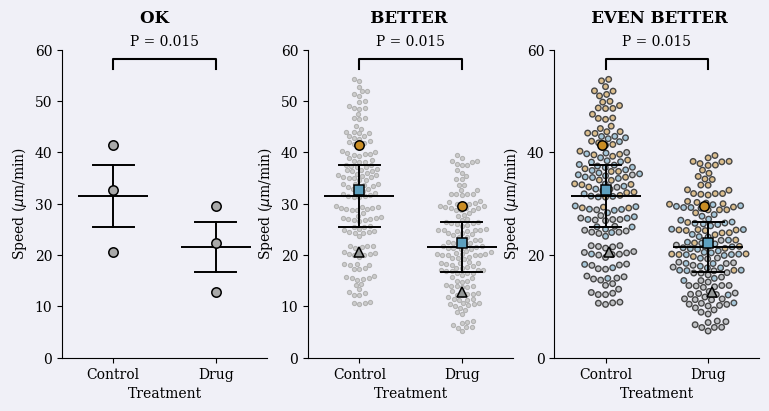

In [14]:
#| label: fig-good-figure
#| fig-cap: "Replica of good figure from @lord_superplots_2020"

# Create 'good' figure

# Iniziatilize figure with background color from original figure
fig, axes = plt.subplots(1,3, figsize=(9,4), facecolor='#F0F0F7')

# Create figure for each subplot
create_ok_plot(df, axes[0])
create_better_plot(df, axes[1])
create_superplot(df, axes[2])

# Add label in the stupidiest way I could find
fig.suptitle('            OK                                   BETTER                         EVEN BETTER', fontweight='bold')
# Save figure without padding
fig.savefig('../figures/good-figure.pdf', bbox_inches='tight', pad_inches=0, transparent=True)